[source](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

In [1]:
from __future__ import unicode_literals, print_function, division

from io import open
import glob
import os

def findFiles(path):
    return glob.glob(path)

print(findFiles("nlp_data/data/names/*.txt"))

['nlp_data/data/names/Czech.txt', 'nlp_data/data/names/German.txt', 'nlp_data/data/names/Arabic.txt', 'nlp_data/data/names/Japanese.txt', 'nlp_data/data/names/Chinese.txt', 'nlp_data/data/names/Vietnamese.txt', 'nlp_data/data/names/Russian.txt', 'nlp_data/data/names/French.txt', 'nlp_data/data/names/Irish.txt', 'nlp_data/data/names/English.txt', 'nlp_data/data/names/Spanish.txt', 'nlp_data/data/names/Greek.txt', 'nlp_data/data/names/Italian.txt', 'nlp_data/data/names/Portuguese.txt', 'nlp_data/data/names/Scottish.txt', 'nlp_data/data/names/Dutch.txt', 'nlp_data/data/names/Korean.txt', 'nlp_data/data/names/Polish.txt']


In [4]:
import unicodedata
import string

all_letters = string.ascii_letters+ ".,:''"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return "".join(c for c in unicodedata.normalize("NFD", s) 
                  if unicodedata.category(c) != "Mn" and c in all_letters)

print(unicode_to_ascii("Ślusàrski"))

Slusarski


In [7]:
category_lines = {}
all_category = []

def read_lines(filename):
    with open(filename, encoding = "utf-8") as f:
        lines = f.read().strip().split("\n")
    return [unicode_to_ascii(line) for line in lines]

for filename in findFiles("nlp_data/data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_category.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_category)

In [9]:
category_lines.keys()

dict_keys(['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish'])

In [10]:
count_dict = {}
for i in category_lines.keys():
    count_dict[i] = len(category_lines[i])
count_dict

{'Czech': 519,
 'German': 724,
 'Arabic': 2000,
 'Japanese': 991,
 'Chinese': 268,
 'Vietnamese': 73,
 'Russian': 9408,
 'French': 277,
 'Irish': 232,
 'English': 3668,
 'Spanish': 298,
 'Greek': 203,
 'Italian': 709,
 'Portuguese': 74,
 'Scottish': 100,
 'Dutch': 297,
 'Korean': 94,
 'Polish': 139}

In [12]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor("J"))
print(lineToTensor("Jones").size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Build Model

In [46]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i20 = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i20(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)        

In [19]:
input = letterToTensor("A")
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9420, -2.9145, -2.8178, -2.8865, -2.9902, -2.9545, -2.7911, -2.8570,
         -2.8888, -2.8712, -2.9051, -2.8526, -2.9584, -2.8239, -2.9617, -2.9148,
         -2.8442, -2.8785]], grad_fn=<LogSoftmaxBackward>)


## Training

In [20]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_category[category_i], category_i

print(category_from_output(output))

('Russian', 6)


In [30]:
import random

def randomChoice(l):  #choosing one element from the list
    return l[random.randint(0, len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_category)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_category.index(category)], dtype = torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor 

for i in range(10):
    c, l, c_t, l_t = randomTrainingExample()
    print(c, "/", l)

Japanese / Ouchi
Italian / Robustelli
Chinese / Quan
Dutch / Akkeren
Greek / Malihoudis
Czech / Urbanek
Irish / O'Doherty
German / Bosch
Chinese / Bao
Vietnamese / Tron


In [31]:
criterion = nn.NLLLoss()

In [47]:
learning_rate = 0.001

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate * p.grad.data)
    
    return output, loss.item()    

In [48]:
import time
import math

n_iter = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_loss = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return "%dm %ds" %(m,s)

start = time.time()

for iter in range(1, n_iter+1):
    c, l, c_t, l_t = randomTrainingExample()
    output, loss = train(c_t, l_t)
    current_loss +=loss
    
    if iter % print_every == 0:
        g, g_i = category_from_output(output)
        correct = "정답" if g == c else '땡 (' + c + ")"
        print('%d %d%% (%s) %.4f %s / %s %s' 
              % (iter, iter / n_iter * 100, timeSince(start), loss, l, g, correct))

    if iter % plot_every == 0:
        all_loss.append(current_loss/plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.8375 Rompa / Czech 땡 (Dutch)
10000 10% (0m 11s) 2.9030 Che / Scottish 땡 (Chinese)
15000 15% (0m 16s) 2.7892 Jizdik / Czech 땡 (Russian)
20000 20% (0m 22s) 2.4338 Winter / German 정답
25000 25% (0m 27s) 2.6184 Ochoa / Arabic 땡 (Spanish)
30000 30% (0m 33s) 1.2800 Tassioglou / Russian 땡 (Greek)
35000 35% (0m 38s) 2.4441 Veitch / Irish 땡 (English)
40000 40% (0m 44s) 1.8677 Le / Korean 땡 (Vietnamese)
45000 45% (0m 50s) 3.0580 Truong / Arabic 땡 (Vietnamese)
50000 50% (0m 55s) 2.4127 Hegney / Dutch 땡 (English)
55000 55% (1m 0s) 1.8044 Milligan / Irish 정답
60000 60% (1m 6s) 3.4937 Till / Vietnamese 땡 (Czech)
65000 65% (1m 12s) 4.1148 Wong / Chinese 땡 (English)
70000 70% (1m 17s) 1.3555 Kruger / German 정답
75000 75% (1m 22s) 2.9787 Sastre / French 땡 (Spanish)
80000 80% (1m 28s) 1.1704 Anderson / Scottish 정답
85000 85% (1m 33s) 2.8012 Solo / Korean 땡 (Spanish)
90000 90% (1m 38s) 1.3042 Chun / Korean 정답
95000 95% (1m 44s) 1.5611 Shoda / Japanese 정답
100000 100% (1m 49s) 1.7075 Antoun /

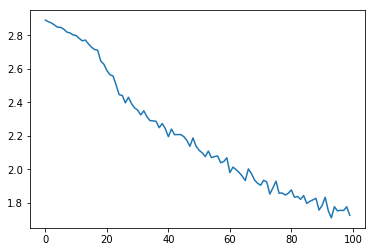

In [50]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_loss)
plt.show()